In [2]:
import random
from optparse import OptionParser

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.collections import LineCollection
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from ourmodels.CRNN import CRNN, cross_validation

In [3]:
%matplotlib inline

Observations: 229
* Fold 1/3
** Epoch 1/3
train iou: 0.000000
train loss: 0.614590
test iou: 0.000000
test loss: 0.542613
** Epoch 2/3
train iou: 0.401106
train loss: 0.425865
test iou: 0.565250
test loss: 0.323151
** Epoch 3/3
train iou: 0.596481
train loss: 0.328017
test iou: 0.545268
test loss: 0.331087
* Fold 2/3
** Epoch 1/3
train iou: 0.006047
train loss: 0.617084
test iou: 0.000000
test loss: 0.615872
** Epoch 2/3
train iou: 0.000000
train loss: 0.585388
test iou: 0.000000
test loss: 0.584946
** Epoch 3/3
train iou: 0.000373
train loss: 0.557266
test iou: 0.040726
test loss: 0.548343
* Fold 3/3
** Epoch 1/3
train iou: 0.084085
train loss: 0.574446
test iou: 0.000399
test loss: 0.507902
** Epoch 2/3
train iou: 0.205803
train loss: 0.509010
test iou: 0.110586
test loss: 0.477234
** Epoch 3/3
train iou: 0.425769
train loss: 0.405805
test iou: 0.542817
test loss: 0.339155
--------
Fold 1/3:
Last train IOU: 0.5964805483818054
Last test IOU: 0.5452683568000793
Average test F1 score: 0

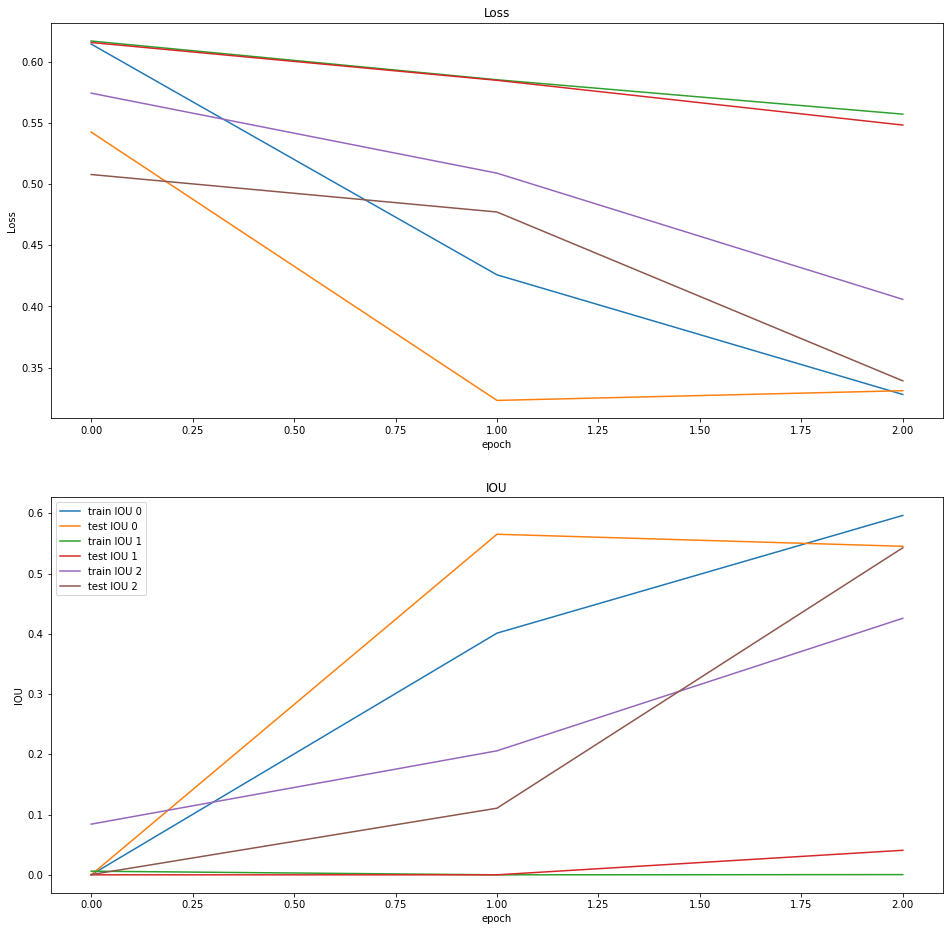

In [6]:
threshold = 0.5
fold_ks = 1
pics_num = 0


# read data
data = pd.read_csv("data/train.csv")
observations = data["id"].unique()
print(f"Observations: {len(observations)}")

data_by_id = data.groupby(['id', ])

data_by_id_list = [data_by_id.get_group(x) for x in data_by_id.groups]

X = []
Y = []

for sample_data in data_by_id_list:
    sample_data_increments = sample_data["x"][1:].values - sample_data["x"][:-1].values
    sample_data_derivatives = sample_data_increments / sample_data["x"][1:].values
    x = torch.from_numpy(sample_data_derivatives).view(1, 1, -1).double()
    X.append(x)
    y = torch.from_numpy(sample_data["y"][1:].values).double()  # .view(1, -1)
    Y.append(y)

X = np.array(X, dtype=object)
Y = np.array(Y, dtype=object)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CRNN().double()
max_epochs = 3
threshold = 0.0005
opt = optim.Adam(model.parameters(), lr=1e-2)
loss_crit = nn.BCEWithLogitsLoss()
lr_decay = optim.lr_scheduler.ExponentialLR(
    optimizer=opt, gamma=0.99)

model = model.to(device)

cross_validation(
        model, opt, loss_crit, lr_decay, max_epochs, X, Y, device, pics_num)